In [1]:
"""
Importing necessary libraries 
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Reading the data 
"""
df = pd.read_csv('AB_NYC_2019.csv')

#creating a new dataframe consisting of relevant columns to be used for analysis
bnb = df[['neighbourhood_group',
'room_type',
'latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']]

In [3]:
"""
Viewing the first 5 rows of the data
"""
bnb.head()

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,NaN,1,365
3,Brooklyn,Entire home/apt,40.68514,-73.95976,89,1,270,4.64,1,194
4,Manhattan,Entire home/apt,40.79851,-73.94399,80,10,9,0.10,1,0


In [4]:
"""
Checking the data types of the columns
"""
bnb.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
"""
Checking missing values
"""
bnb.isna().sum()

neighbourhood_group                   0
room_type                             0
latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Only the reviews per month column has missing values

In [6]:
"""
filling missing values with 0
"""
bnb['reviews_per_month'] = bnb['reviews_per_month'].fillna(0)

In [7]:
"""
The most frequent observation mode in neighborhood_group
"""
highest_neighborhood = bnb['neighbourhood_group'].mode()
count_of_highest_neighborhood = len(bnb[bnb.neighbourhood_group=='Manhattan'])
print("The most frequent neighborhood is",  highest_neighborhood[0], "with a freqeuncy of ", count_of_highest_neighborhood)

The most frequent neighborhood is Manhattan with a freqeuncy of  21661


<AxesSubplot:>

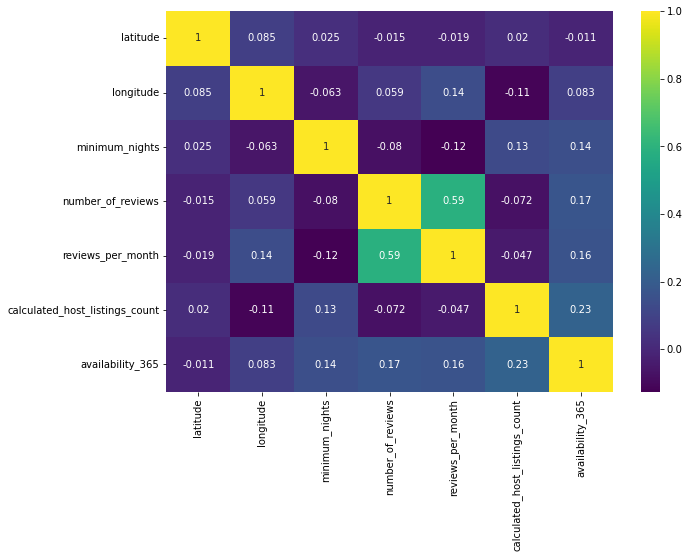

In [8]:
"""
Creating correlation matrix of all numeric columns
"""
plt.figure(figsize=(10,7))
#creating a list of all numerical columns
numerical = ['latitude', 'longitude', 'minimum_nights',	'number_of_reviews', 
             'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
#checking correlation
correlation_matrix = bnb[numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')

The two features with the highest correlation are 'reviews_per_month' and 'number_of_reviews'

In [9]:
"""
Creating above average variable 
"""
bnb['above_average'] = (bnb['price'] >= 152 ).astype(int)
bnb = bnb.drop('price', axis=1)

In [10]:
"""
Splitting the data 
"""
from sklearn.model_selection import train_test_split
bnb_full_train, bnb_test = train_test_split(bnb, test_size=0.2, random_state=42)
bnb_train, bnb_val = train_test_split(bnb_full_train, test_size=0.25, random_state=42)

"""
Extracting target variables from the splits
"""
y_train = bnb_train.above_average.values
y_val = bnb_val.above_average.values
y_test = bnb_test.above_average.values

In [11]:
"""
Checking mutual info score of categorical variables 
"""
#importing mutual_info_score
from sklearn.metrics import mutual_info_score

#creating a list of categorical columns
categorical = ['neighbourhood_group','room_type']

#This function computes the mutual info score between the price and a specifiec categorical column
#params: pandas series
#returns: mutual_info_score 
#rtype: float 
def mi(series):
    return round(mutual_info_score(series, bnb_full_train['above_average']),2)


In [12]:
"""
Appplying the mi function to the categorical columns in the dataset
"""
bnb_full_train[categorical].apply(mi)

neighbourhood_group    0.05
room_type              0.14
dtype: float64

room_type has the higher mutual info score

In [13]:
"""
Alternate method of preparing Data:
Using StandardScaler and OneHotEncider
"""
# """
# Training a Logistic Regression Model and fitting our train data
# """
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler

# #scaling the features
# scaler = StandardScaler()
# ohe = OneHotEncoder(sparse=False)
# bnb_train_num = scaler.fit_transform(bnb_train[numerical])
# bnb_train_cat = ohe.fit_transform(bnb_train[categorical])
# X_train = np.column_stack([bnb_train_cat, bnb_train_num])

# #creating an instance of the logistic regression model
# model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)

# #Training the model 
# model.fit(X_train, y_train)

'\nAlternate method of preparing Data:\nUsing StandardScaler and OneHotEncider\n'

In [14]:
"""
Training a Logistic Regression Model and fitting our train data
"""
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

#DictVectorizer performs one hot enconding on categorical columns
dv = DictVectorizer()

#convert train data to dictionary
train_dict = bnb_train[numerical + categorical].to_dict(orient='records')

#one hot encoding
X_train = dv.fit_transform(train_dict)

#creating an instance of the logistic regression model
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=1000)

#Training the model 
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
"""
Checking accuracy of the model on validation data set 
"""
from sklearn.metrics import accuracy_score

#convert train data to dictionary
val_dict = bnb_val[numerical + categorical].to_dict(orient='records')

#one hot encoding
X_val = dv.transform(val_dict)

#predicting for the validation data
y_pred = model.predict(X_val)

#checking the accuracy
accuracy = round(accuracy_score(y_pred, y_val),2)
print(accuracy)

0.79


In [16]:
"""
Training and testing by feature omission
"""
real_score = accuracy
columns = ['neighbourhood_group', 'room_type', 'latitude', 'longitude',
           'minimum_nights','number_of_reviews','reviews_per_month',
            'calculated_host_listings_count', 'availability_365']

for c in columns:
    cols = columns.copy()
    cols.remove(c)
    train_dict = bnb_train[cols].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    val_dict = bnb_val[cols].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict(X_val)
    
    score = accuracy_score(y_pred, y_val)
    print(c +':', 'score:', score, 'difference:', real_score - score )


neighbourhood_group: score: 0.7509970344616014 difference: 0.03900296553839866
room_type: score: 0.7283975866653032 difference: 0.06160241333469685
latitude: score: 0.7867880151344718 difference: 0.0032119848655282057
longitude: score: 0.7869925350240311 difference: 0.003007464975968932
minimum_nights: score: 0.7916964924838941 difference: -0.0016964924838940298
number_of_reviews: score: 0.7911851927599959 difference: -0.0011851927599958456
reviews_per_month: score: 0.7907761529808774 difference: -0.0007761529808774092
calculated_host_listings_count: score: 0.7891399938644034 difference: 0.0008600061355966693
availability_365: score: 0.7812659781163718 difference: 0.008734021883628262


The feature with the smallest differene is number_of_reviews

In [17]:
"""
Using Ridge Regression to check accuracy
"""
df['price'] = np.log1p(df['price'])
df = df.fillna(0)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
y_train = df_train['price'].values
y_val = df_val['price'].values
y_test = df_test['price'].values

del df_train['price']
del df_test['price']
del df_val['price']

dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)

val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
mse = mean_squared_error

tune_param = [0, 0.01, 0.1, 1, 10]
for a in tune_param:    
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)    
    score = np.sqrt(mse(y_pred, y_val))
        
    print("The score for tune parameter", a, "=", round(score,3))




The score for tune parameter 0 = 0.497
The score for tune parameter 0.01 = 0.497
The score for tune parameter 0.1 = 0.497
The score for tune parameter 1 = 0.497
The score for tune parameter 10 = 0.498


The alpha value with the smallest score is 0